In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import os
from glob import glob
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
#from dataloader import inaturalist
#from model import Classifier
import torch.optim as optim
import time
import gc
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# For Animal Kingdom Classification
# !gdown 1Qh9WE8Y7_0p36Q55DIHx51r_gNqUaJue

# For DeepFake Detection
# !gdown 1abbv0V6ItAFCKHGO_FebLRGRclebZWlW
# !unzip deepfake_data.zip

# For Sports Classification
# !gdown 1VEDTIGOavtFKncqXpyF2jtxKogoF7Jnc

# For Human Action Classification
# !gdown 1L03JuLp4kjtXCUSRt4mb2CeMo2f01Vny

# For House Price Prediction
# !gdown 1hWqLvwyzs2evNlg0vYVeJ6v4p_bK9EcI

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, mode = 'Train', transform = True):
        self.data_dir = root_dir
        self.mode = mode
        self.transforms = transform
        self._init_dataset()
        if transform:
            self._init_transform()

    def _init_dataset(self):
        self.files = []
        self.labels = []
        dirs = sorted(os.listdir(os.path.join(self.data_dir, self.mode)))
        for dir in range(len(dirs)):
            files = sorted(glob(os.path.join(self.data_dir, self.mode, dirs[dir], '*.jpg')))
            self.labels += [dir]*len(files)
            self.files += files
        #------YOUR CODE HERE-----#

    def _init_transform(self):
        self.transform = transforms.Compose([
            #------YOUR CODE HERE-----#
            # Useful link for this part: https://pytorch.org/vision/stable/transforms.html
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],std  = [ 0.229, 0.224, 0.225 ])
        ])

    def __getitem__(self, index):
        #------YOUR CODE HERE-----#
        img = Image.open(self.files[index]).convert('RGB')
        label = self.labels[index]

        if self.transforms:
            img = self.transform(img)

        label = torch.tensor(label, dtype = torch.long)
        return img, label

    def __len__(self):
        return len(self.files)

In [ ]:
class BasicBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc1 = nn.Linear(512, 2)
        self.fc1 = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape
        x = self.fc1(x)
        #x = self.fc(x)

        return x

def ResNet18(num_classes=2, blocks = [2, 2, 2, 2]):
    return ResNet(BasicBlock, blocks, num_classes)


In [ ]:
batch_size = 256
epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

############################################# DEFINE DATALOADER #####################################################
train_dataset = ClassificationDataset(root_dir='/content/Dataset/', mode='Train')
valset = ClassificationDataset(root_dir='/content/Dataset/', mode = 'Validation')
test_dataset = ClassificationDataset(root_dir='/content/Dataset/', mode = 'Test')

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

#################################### HELPER FUNCTIONS ##############################################################

def accuracy(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct/total
####################################################################################################################

def make_tensor(tensor):
  if torch.cuda.is_available():
    return torch.cuda.FloatTensor(tensor)
  else:
    return torch.FloatTensor(tensor)

####################################################################################################################

def train(model, dataset, optimizer, criterion, device):
    '''
    Write the function to train the model for one epoch
    Feel free to use the accuracy function defined above as an extra metric to track
    '''
    #------YOUR CODE HERE-----#
    train_loss_batch = []
    accu_train_batch = []
    model.train()
    for idx,(images, labels) in enumerate(dataset):

      images = images.to(device)
      labels = labels.to(device)

    #   labels = torch.subtract(labels, 1)
      #Forward Pass
      output = model(images)
      train_loss = criterion(output,labels)
      train_loss_batch.append(train_loss)
      acc = accuracy(output, labels)
      accu_train_batch.append(acc)
    #   print(f"Batch: {idx + 1}   Train Loss: {train_loss}   Accuracy: {acc}")
      # Backward
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
    epoch_train_losses.append(sum(train_loss_batch)/len(dataset))
    accu_train_epoch.append(sum(accu_train_batch)/len(dataset))
    print(f"Train Epoch Loss: {sum(train_loss_batch)/len(dataset)}   Train Epoch Accuracy: {sum(accu_train_batch)/len(dataset)}")

def test(model, dataset, criterion, device):
    '''
    Write the function to validate the model after each epoch
    Feel free to use the accuracy function defined above as an extra metric to track
    '''
    #------YOUR CODE HERE-----#
    test_loss_batch = []
    accu_test_batch = []
    model.eval()
    for idx,(images, labels) in enumerate(dataset):
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        # labels = torch.subtract(labels, 1)
        #Forward Pass
        output = model(images)
        # Loss
        test_loss = criterion(output,labels)
        test_loss_batch.append(test_loss)
        acct = accuracy(output, labels)
        accu_test_batch.append(acct)
        #print(f"Batch: {idx + 1}   Test Loss: {test_loss}   Accuracy: {acct}")
    epoch_test_losses.append((sum(test_loss_batch))/len(dataset))
    accu_test_epoch.append((sum(accu_test_batch))/len(dataset))
    print(f"Test Epoch Loss: {(sum(test_loss_batch))/len(dataset)} Test Epoch Accuracy: {(sum(accu_test_batch))/len(dataset)}")

def eval(model, dataset, criterion, device):
    '''
    Write the function to validate the model after each epoch
    Feel free to use the accuracy function defined above as an extra metric to track
    '''
    #------YOUR CODE HERE-----#
    val_loss_batch = []
    accu_val_batch = []
    model.eval()
    for idx,(images, labels) in enumerate(dataset):
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        # labels = torch.subtract(labels, 1)
        #Forward Pass
        output = model(images)
        # Loss
        val_loss = criterion(output,labels)
        val_loss_batch.append(val_loss)
        acc = accuracy(output, labels)
        accu_val_batch.append(acc)
        #print(f"Batch: {idx + 1}   Val Loss: {val_loss}   Accuracy: {accv}")
    epoch_val_losses.append((sum(val_loss_batch))/len(dataset))
    accu_val_epoch.append((sum(accu_val_batch))/len(dataset))
    print(f"Val Epoch Loss: {(sum(val_loss_batch))/len(dataset)} Val Epoch Accuracy: {(sum(accu_val_batch))/len(dataset)}")
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
import mlflow
import os

# Set up MLflow tracking
mlflow_tracking_uri = "http://127.0.0.1:5100"
mlflow.login()
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [ ]:
### Experiment 1 

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-pytorch-deepfake"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

lr = 0.001
loss = nn.CrossEntropyLoss()
model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

with mlflow.start_run():
    for epoch in range(epochs):

        start_time = time.monotonic()
        print(f"Epoch: {epoch + 1}")
        train(model, trainloader, optimizer, loss, device)
        test(model, testloader, loss, device)
        eval(model, valloader, loss, device)
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()
    
    mlflow.log_metrics({"log_metrics_loss": sum(epoch_test_losses)/len(epoch_test_losses), "log_metrics_accuracy": sum(accu_test_epoch)/len(accu_test_epoch)})
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("config", "basic")

In [ ]:
### Experiment 2 

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-pytorch-deepfake"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

lr = 0.00001
loss = nn.CrossEntropyLoss()
model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

with mlflow.start_run():
    for epoch in range(epochs):

        start_time = time.monotonic()
        print(f"Epoch: {epoch + 1}")
        train(model, trainloader, optimizer, loss, device)
        test(model, testloader, loss, device)
        eval(model, valloader, loss, device)
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()
    
    mlflow.log_metrics({"log_metrics_loss": sum(epoch_test_losses)/len(epoch_test_losses), "log_metrics_accuracy": sum(accu_test_epoch)/len(accu_test_epoch)})
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("config", "Lesser Learning Rate")

In [ ]:
### Experiment 3

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-pytorch-deepfake"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

lr = 0.1
loss = nn.CrossEntropyLoss()
model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

with mlflow.start_run():
    for epoch in range(epochs):

        start_time = time.monotonic()
        print(f"Epoch: {epoch + 1}")
        train(model, trainloader, optimizer, loss, device)
        test(model, testloader, loss, device)
        eval(model, valloader, loss, device)
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()
    
    mlflow.log_metrics({"log_metrics_loss": sum(epoch_test_losses)/len(epoch_test_losses), "log_metrics_accuracy": sum(accu_test_epoch)/len(accu_test_epoch)})
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("config", "More Learning Rate")

In [ ]:
### Experiment 4

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-pytorch-deepfake"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

lr = 0.001
loss = nn.CrossEntropyLoss()
model = ResNet18().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr)

with mlflow.start_run():
    for epoch in range(epochs):

        start_time = time.monotonic()
        print(f"Epoch: {epoch + 1}")
        train(model, trainloader, optimizer, loss, device)
        test(model, testloader, loss, device)
        eval(model, valloader, loss, device)
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()
    
    mlflow.log_metrics({"log_metrics_loss": sum(epoch_test_losses)/len(epoch_test_losses), "log_metrics_accuracy": sum(accu_test_epoch)/len(accu_test_epoch)})
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("config", "SGD Optimizer")

In [ ]:
### Experiment 5 

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-pytorch-deepfake"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

lr = 0.001
loss = nn.CrossEntropyLoss()
model = ResNet18([1, 1, 1, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

with mlflow.start_run():
    for epoch in range(epochs):

        start_time = time.monotonic()
        print(f"Epoch: {epoch + 1}")
        train(model, trainloader, optimizer, loss, device)
        test(model, testloader, loss, device)
        eval(model, valloader, loss, device)
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()
    
    mlflow.log_metrics({"log_metrics_loss": sum(epoch_test_losses)/len(epoch_test_losses), "log_metrics_accuracy": sum(accu_test_epoch)/len(accu_test_epoch)})
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("config", "Lesser Number of Parameters")

In [ ]:
### Experiment 6 

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-pytorch-deepfake"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

lr = 0.001
loss = nn.CrossEntropyLoss()
model = ResNet18([3, 3, 3, 3]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)

with mlflow.start_run():
    for epoch in range(epochs):

        start_time = time.monotonic()
        print(f"Epoch: {epoch + 1}")
        train(model, trainloader, optimizer, loss, device)
        test(model, testloader, loss, device)
        eval(model, valloader, loss, device)
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()
    
    mlflow.log_metrics({"log_metrics_loss": sum(epoch_test_losses)/len(epoch_test_losses), "log_metrics_accuracy": sum(accu_test_epoch)/len(accu_test_epoch)})
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("config", "More Number of Parameters")

In [ ]:
### Experiment 7 

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

# Set up MLflow experiment and tracking
mlflow_experiment_name = "mlflow-pytorch-deepfake"
mlflow.set_experiment(mlflow_experiment_name)
track = "custom_logger"

lr = 0.001
loss = nn.CrossEntropyLoss()
model = ResNet18([3, 3, 3, 3]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)

with mlflow.start_run():
    for epoch in range(epochs):

        start_time = time.monotonic()
        print(f"Epoch: {epoch + 1}")
        train(model, trainloader, optimizer, loss, device)
        test(model, testloader, loss, device)
        eval(model, valloader, loss, device)
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()
    
    mlflow.log_metrics({"log_metrics_loss": sum(epoch_test_losses)/len(epoch_test_losses), "log_metrics_accuracy": sum(accu_test_epoch)/len(accu_test_epoch)})
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("config", "Regularisation")

Fake
Fake
Fake
Fake
Real
Real
Real
Real
Fake
Real
Fake
Real
Fake
Fake
Fake
Real
Fake
Real
Fake
Real
Real
Fake
Real
Fake
Fake


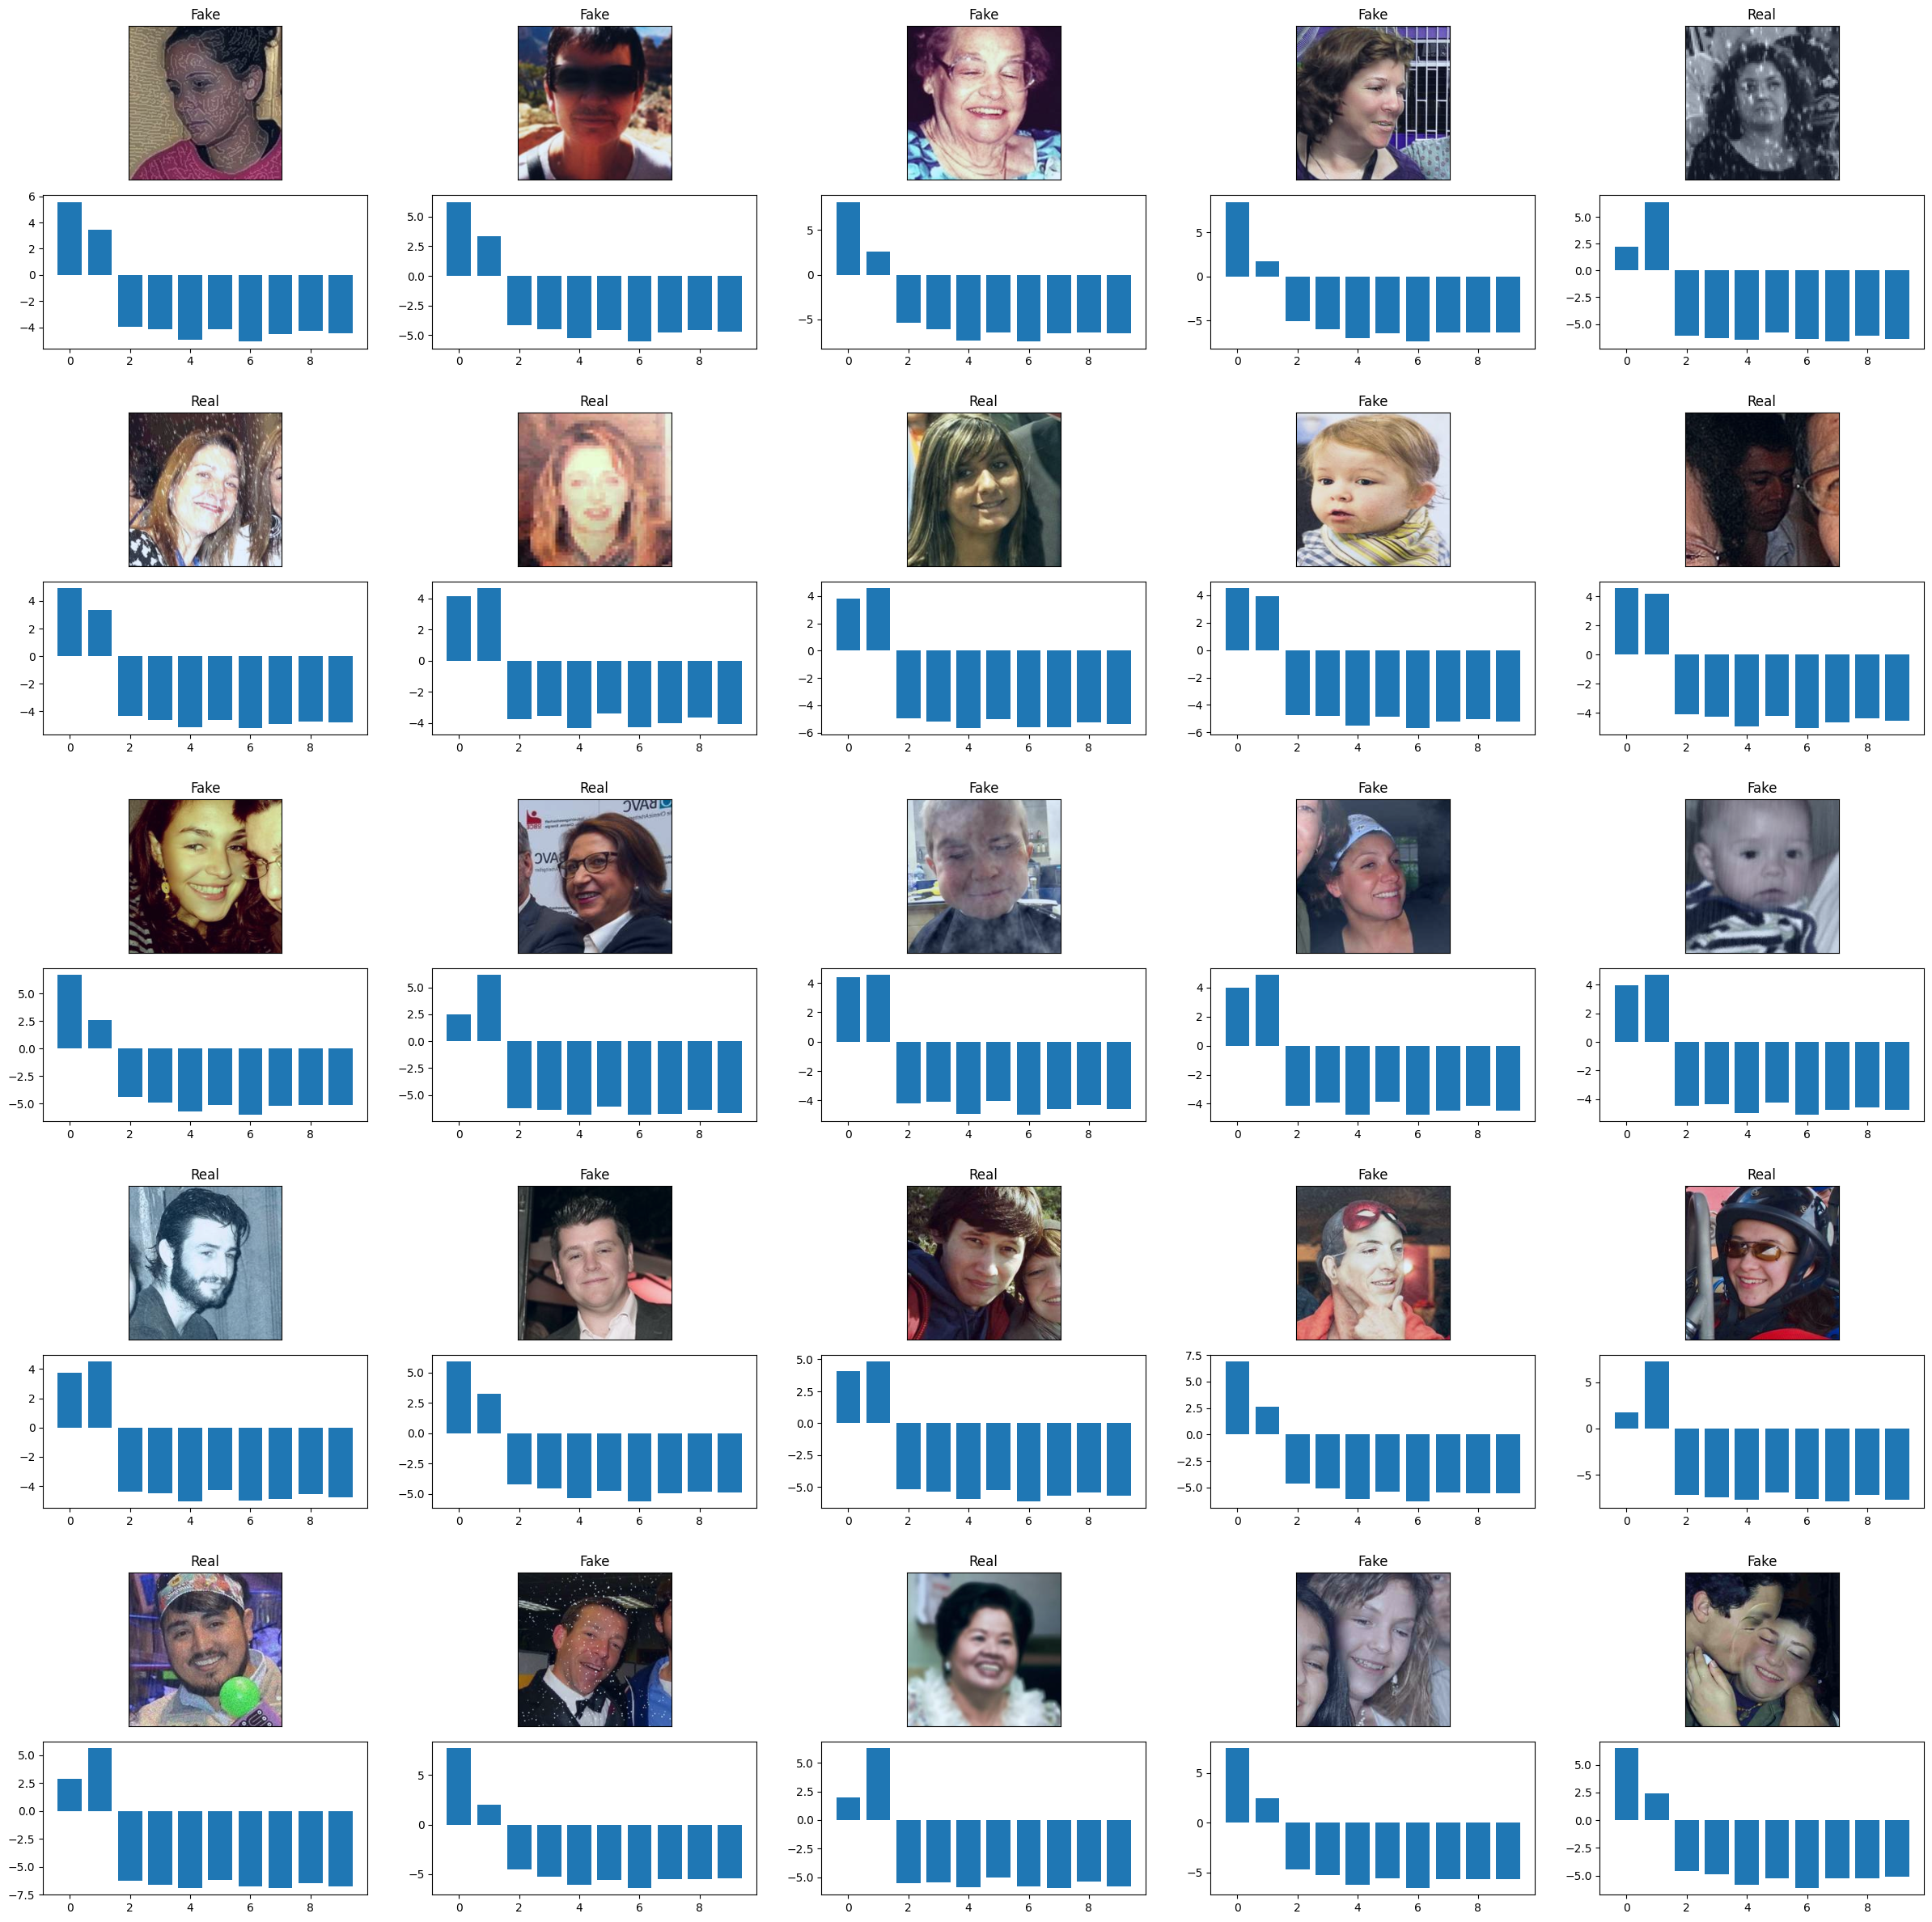

In [ ]:
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
from random import randint
import numpy as np

fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)
get_classlabels = {0:'Fake', 1:'Real'}

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(test_dataset))
    # img = test_dataset[2][0]
    # print(img.shape)
    # break

    pred_image = test_dataset[rnd_number][0].cuda().unsqueeze(0)
    # pred_class = get_classlabel(torch.argmax(model(pred_image)))
    pred_class = get_classlabels[test_dataset[rnd_number][1].item()]
    pred_prob = model(pred_image).reshape(10)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            pred_image = (pred_image - torch.min(pred_image))/(torch.max(pred_image) - torch.min(pred_image))
            ax.imshow(pred_image[0].permute(1, 2, 0).cpu().numpy())
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5,6,7,8,9],pred_prob.detach().cpu().numpy())
            fig.add_subplot(ax)


fig.show()

In [ ]:
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.plot(epoch_test_losses, label='Test Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(accu_train_epoch, label='Accuracy Training')
plt.plot(accu_val_epoch, label='Accuracy Validation')
plt.plot(accu_test_epoch, label='Accuracy Test')
plt.legend()
plt.show()